In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

%matplotlib inline
sns.set() # Revert to matplotlib defaults

import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [2]:
train_raw = pd.read_csv("train.csv", header=0)
test_df = pd.read_csv("test.csv", header=0)
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Making a copy of the training data
train_df = train_raw.copy()
print(train_df.shape)

(891, 12)


In [70]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


## Preprocessing the data

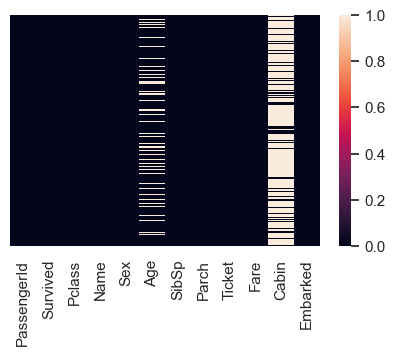

In [4]:
#Visualizing null values in each column
fig = plt.figure(figsize=(5,3))
fig = sns.heatmap(train_df.isna(), yticklabels=False)
plt.show()

In [5]:
#Checking the data types of all the features
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
#Deleting Cabin column since it has too many null values
#Also deleting other columns not useful in building a model
train_df_2 = train_df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
train_df_2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


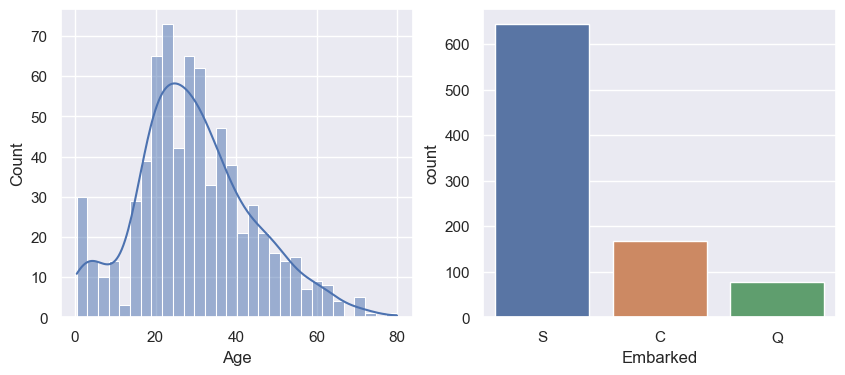

In [7]:
#Visualizing distribution of Age and Embarked values
fig, axes = plt.subplots(1,2,figsize=(10,4))
fig = sns.histplot(x='Age', data=train_df_2, ax=axes[0], bins=30, kde=True)
fig = sns.countplot(x="Embarked", data=train_df_2, ax=axes[1])
plt.show()

<AxesSubplot: xlabel='Pclass', ylabel='Age'>

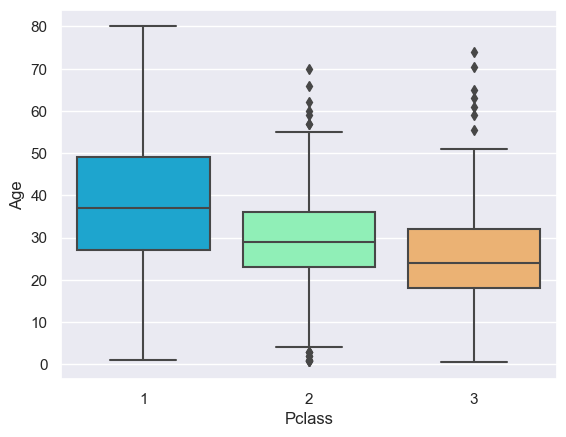

In [8]:
#Creating boxplot to view if there is any relation between Age and Pclass
sns.boxplot(x='Pclass', y='Age', data=train_df_2, palette='rainbow')

In [9]:
#Calculating mean age values for each Pclass
pclass_dict={}
for i in train_df_2['Pclass'].unique():
    pclass_dict[i] = train_df_2.loc[train_df_2['Pclass'] == i]['Age'].mean()
    print(f"For Pclass {i}: Mean Age: {pclass_dict[i]}")

For Pclass 3: Mean Age: 25.14061971830986
For Pclass 1: Mean Age: 38.233440860215055
For Pclass 2: Mean Age: 29.87763005780347


In [10]:
#Filling null values for age as per above criteria
def fillna_age(cols, pclass_dict):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return round(pclass_dict[1],2)
        elif Pclass == 2:
            return round(pclass_dict[2],2)
        else:
            return round(pclass_dict[3],2)
    else:
        return Age

In [11]:
#Applying the above function
for index, row in train_df_2.iterrows():
    cols = [row['Age'],row['Pclass']]
    train_df_2['Age'] = fillna_age(cols,pclass_dict)
train_df_2['Age'].isna().sum()

0

In [12]:
#Checking value counts for Embarked attribute
train_df_2['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
#Filling the null values with mode of Embarked values (i.e., "S")
train_df_nonull = train_df_2.copy()
train_df_nonull['Embarked'] = train_df_nonull['Embarked'].fillna("S")
train_df_nonull.isna().any()

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

<AxesSubplot: >

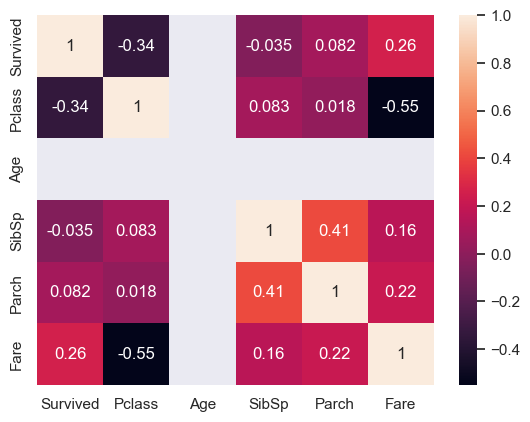

In [14]:
#Checking correlation between features
correlations = train_df_nonull.corr()
sns.heatmap(correlations, annot=True)

#No features have a high correlation with each other

In [15]:
#Checking out unique values of all categorical features
cat_features = ['Pclass','Sex','Embarked']
for feature in cat_features:
    print(feature,f" Data type: {train_df_nonull[feature].dtype}")
    print(train_df_nonull[feature].unique())
    print("-----------------------------------------------")

Pclass  Data type: int64
[3 1 2]
-----------------------------------------------
Sex  Data type: object
['male' 'female']
-----------------------------------------------
Embarked  Data type: object
['S' 'C' 'Q']
-----------------------------------------------


In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
one_hot_encode = encoder.fit_transform(train_df_nonull[[feature for feature in cat_features]])

categories=[]
for index,feature in enumerate(encoder.categories_):
    for category in feature:
        categories.append(f"{cat_features[index]}_{category}")

encoded_df = pd.DataFrame(data=one_hot_encode, columns=categories)
encoded_df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
887,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
888,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [17]:
encoder.categories_

[array([1, 2, 3], dtype=int64),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object)]

In [32]:
#Merging the encoded df with the data
train_df_preprocessed = pd.concat([train_df_nonull,encoded_df],axis=1)
#Removing categorical features since they are no longer required
train_df_preprocessed = train_df_preprocessed.drop(cat_features,axis=1)
train_df_preprocessed.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,32.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,32.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,32.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,32.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,32.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [71]:
print(train_df_preprocessed.columns.values)

['Survived' 'Age' 'SibSp' 'Parch' 'Fare' 'Pclass_1' 'Pclass_2' 'Pclass_3'
 'Sex_female' 'Sex_male' 'Embarked_C' 'Embarked_Q' 'Embarked_S']


## Train-test split

In [46]:
from sklearn.model_selection import train_test_split
X = train_df_preprocessed.drop(['Survived'], axis=1)
y = train_df_preprocessed['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=24,stratify=y)

In [47]:
print(f"Training Data: X:{X_train.shape} y:{y_train.shape}")
print(f"Testing Data: X:{X_test.shape} y:{y_test.shape}")

Training Data: X:(712, 12) y:(712,)
Testing Data: X:(179, 12) y:(179,)


## Logistic Regression model

In [48]:
# Creating a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

LogisticRegression()

In [49]:
y_pred = logit_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



## Random Forest Classifier Model

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=44)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=44)

In [51]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       110
           1       0.85      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



## Naive Bayes Classifier Model

In [52]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [53]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       110
           1       0.59      0.33      0.43        69

    accuracy                           0.65       179
   macro avg       0.63      0.59      0.59       179
weighted avg       0.64      0.65      0.63       179



## SVM model

In [54]:
from sklearn.svm import LinearSVC
svm_model=LinearSVC(C=0.0001)
svm_model.fit(X_train, y_train)

LinearSVC(C=0.0001)

In [55]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.95      0.78       110
           1       0.74      0.20      0.32        69

    accuracy                           0.66       179
   macro avg       0.70      0.58      0.55       179
weighted avg       0.69      0.66      0.60       179



## Decision Trees model

In [56]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.01,criterion='gini')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5)

In [57]:
y_pred = dt_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



## kNN model

In [58]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=1)

In [59]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       110
           1       0.70      0.68      0.69        69

    accuracy                           0.77       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.77      0.76       179



## XGBoost Classifier

In [61]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [62]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



## Choosing XGBoost model out of the above models

## Hyperparameter tuning

In [64]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameters to tune
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 500, 1000, 2000]
}


# Initialize XGBoost classifier
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Use RandomizedSearchCV to search for best hyperparameters
random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)

# Fit the model on the training data
random_search.fit(X_train, y_train)
# Print best hyperparameters and accuracy
print('Best hyperparameters:', random_search.best_params_)
print('Accuracy:', random_search.best_score_)

Best hyperparameters: {'subsample': 0.8, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.8}
Accuracy: 0.8032995173840245


## Retraining the model based on above parameters

In [66]:
final_model = XGBClassifier(objective='binary:logistic',random_state=35)
final_model.set_params(**random_search.best_params_)
final_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=35, ...)

In [67]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



## Pickling the final model

In [68]:
import pickle
pickle.dump(final_model,open("Titanic_Model.pkl","wb"))
pickle.dump(encoder,open("Titanic_Encoder.pkl","wb"))